In [1]:

import sys
import os
import pandas as pd
import numpy as np

sys.path.append(os.path.abspath('../scripts'))

In [2]:
from telecom_analysis import load_data_using_sqlalchemy


Top 10 handsets:
                        handset  usage_count
0              Huawei B528S-23A        19752
1       Apple iPhone 6S (A1688)         9419
2        Apple iPhone 6 (A1586)         9023
3                     undefined         8987
4        Apple iPhone 7 (A1778)         6326
5       Apple iPhone Se (A1723)         5187
6        Apple iPhone 8 (A1905)         4993
7       Apple iPhone Xr (A2105)         4568
8  Samsung Galaxy S8 (Sm-G950F)         4520
9        Apple iPhone X (A1901)         3813
Top 3 manufacturers:
  manufacturer  usage_count
0        Apple        59565
1      Samsung        40839
2       Huawei        34423
Top 5 handsets for Apple:
                   handset  usage_count
0  Apple iPhone 6S (A1688)         9419
1   Apple iPhone 6 (A1586)         9023
2   Apple iPhone 7 (A1778)         6326
3  Apple iPhone Se (A1723)         5187
4   Apple iPhone 8 (A1905)         4993
Top 5 handsets for Samsung:
                        handset  usage_count
0  Samsung Galax

In [14]:
# Define your SQL query
query = "SELECT * FROM xdr_data;"  # Replace with your actual table name

# Load data from PostgreSQL using SQLAlchemy
df_user_engagement = load_data_using_sqlalchemy(query)

# Display the first few rows of the dataframe
if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

Successfully loaded the data


In [15]:
df_user_engagement

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,1.585461e+07,2.501332e+06,8.198936e+06,9.656251e+06,2.780823e+08,1.434415e+07,1.717444e+08,8.814393e+06,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,2.024740e+07,1.911173e+07,1.833841e+07,1.722713e+07,6.087501e+08,1.170709e+06,5.269042e+08,1.505514e+07,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,1.972566e+07,1.469958e+07,1.758779e+07,6.163408e+06,2.295846e+08,3.956300e+05,4.106926e+08,4.215763e+06,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,2.138812e+07,1.514664e+07,1.399465e+07,1.097942e+06,7.995382e+08,1.084972e+07,7.490399e+08,1.279728e+07,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,1.525938e+07,1.896287e+07,1.712458e+07,4.152180e+05,5.277072e+08,3.529801e+06,5.507095e+08,1.391032e+07,38542814.0,569138589.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149996,7.277826e+18,4/29/2019 7:28,451.0,4/30/2019 6:02,214.0,81230.0,2.082022e+14,3.365069e+10,3.548311e+13,D20434A,...,1.619167e+07,1.176343e+07,1.788370e+07,1.967816e+07,5.266097e+08,9.197207e+06,3.264510e+06,1.348742e+07,57628851.0,574175259.0
149997,7.349883e+18,4/29/2019 7:28,483.0,4/30/2019 10:41,187.0,97970.0,2.082019e+14,3.366345e+10,3.566051e+13,D10223C,...,1.387723e+07,8.288284e+06,1.935015e+07,2.129315e+07,6.268931e+08,4.735033e+06,7.121804e+08,2.457758e+06,39135081.0,666648844.0
149998,1.311448e+19,4/29/2019 7:28,283.0,4/30/2019 10:46,810.0,98249.0,2.082017e+14,3.362189e+10,3.572121e+13,T51102A,...,2.266051e+07,1.855903e+06,9.963942e+06,5.065760e+06,5.535395e+08,1.339432e+07,1.211009e+08,1.131473e+07,34912224.0,592786405.0
149999,1.311448e+19,4/29/2019 7:28,696.0,4/30/2019 10:40,327.0,97910.0,2.082021e+14,3.361962e+10,8.618620e+13,L88342B,...,8.817106e+06,8.305402e+06,3.322253e+06,1.317259e+07,3.525370e+08,2.529475e+06,8.147131e+08,1.406930e+06,29626096.0,371895920.0


In [18]:
# Group by MSISDN to aggregate per customer
user_engagement = df_user_engagement.groupby('MSISDN/Number').agg({
    'Dur. (ms)': 'sum',  # Session duration
    'HTTP DL (Bytes)': 'sum',  # Download bytes
    'HTTP UL (Bytes)': 'sum',  # Upload bytes
    'Bearer Id': 'count'  # Session frequency
}).rename(columns={'Dur. (ms)': 'total_session_duration', 
                   'HTTP DL (Bytes)': 'total_download',
                   'HTTP UL (Bytes)': 'total_upload',
                   'Bearer Id': 'session_frequency'})

# Calculate total traffic (download + upload)
user_engagement['total_traffic'] = user_engagement['total_download'] + user_engagement['total_upload']

# Display the top 10 customers per engagement metric
print(user_engagement.sort_values('session_frequency', ascending=False).head(10))  # Top 10 by session frequency
print(user_engagement.sort_values('total_session_duration', ascending=False).head(10))  # Top 10 by session duration
print(user_engagement.sort_values('total_traffic', ascending=False).head(10))  # Top 10 by total traffic

               total_session_duration  total_download  total_upload  \
MSISDN/Number                                                         
0.000000e+00               72446396.0    1.677458e+10   623475823.0   
3.362632e+10                8791927.0    1.720802e+06      327919.0   
3.362578e+10               18553754.0    1.957540e+05       67482.0   
3.361489e+10                9966898.0    7.019594e+07     4999215.0   
3.365973e+10                4035428.0    3.204144e+07     2380402.0   
3.376054e+10                9279434.0    3.286280e+07     3295498.0   
3.367588e+10                4865947.0    9.971896e+07     9930268.0   
3.366716e+10                8744914.0    2.524831e+07      736250.0   
3.362708e+10                4703516.0    1.913830e+06      250316.0   
3.360313e+10                6287761.0    1.070111e+07     1749616.0   

               session_frequency  total_traffic  
MSISDN/Number                                    
0.000000e+00                1066   1.739805e+10

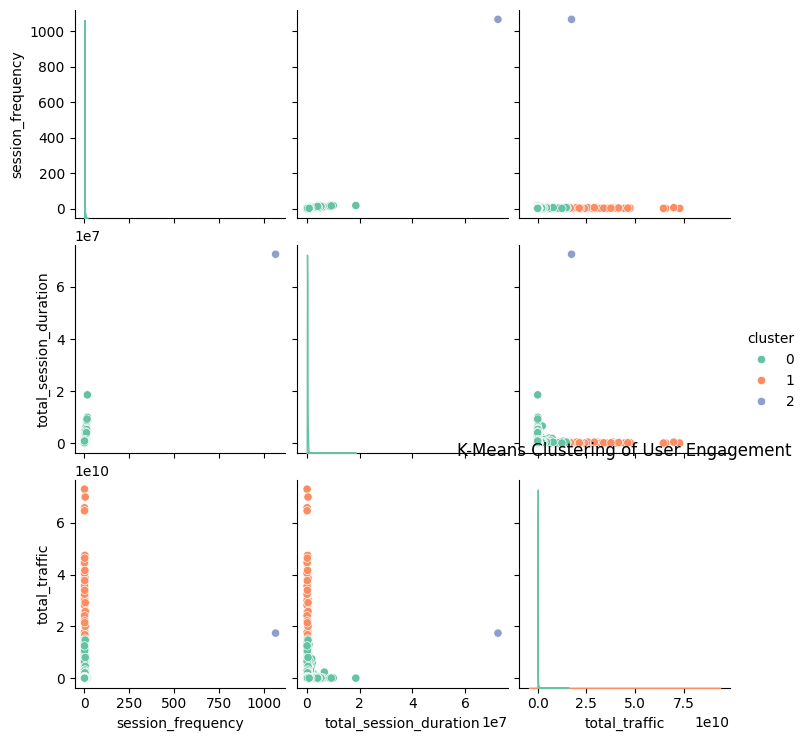

In [19]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Normalize the metrics
scaler = MinMaxScaler()
normalized_metrics = scaler.fit_transform(user_engagement[['session_frequency', 'total_session_duration', 'total_traffic']])

# Apply K-Means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
user_engagement['engagement_cluster'] = kmeans.fit_predict(normalized_metrics)

# Add cluster labels to the user_engagement dataframe
user_engagement['cluster'] = kmeans.labels_

# Visualize the clusters
sns.pairplot(user_engagement, vars=['session_frequency', 'total_session_duration', 'total_traffic'], hue='cluster', palette='Set2')
plt.title('K-Means Clustering of User Engagement')
plt.show()


In [20]:
# Group by cluster and calculate summary statistics for each cluster
cluster_summary = user_engagement.groupby('cluster').agg({
    'session_frequency': ['min', 'max', 'mean', 'sum'],
    'total_session_duration': ['min', 'max', 'mean', 'sum'],
    'total_traffic': ['min', 'max', 'mean', 'sum']
})

print("Cluster Summary Statistics:\n", cluster_summary)


Cluster Summary Statistics:
         session_frequency                            total_session_duration  \
                      min   max         mean     sum                    min   
cluster                                                                       
0                       1    18     1.393330  148823                 7142.0   
1                       1     6     2.488889     112                56123.0   
2                    1066  1066  1066.000000    1066             72446396.0   

                                                total_traffic                \
                max          mean           sum           min           max   
cluster                                                                       
0        18553754.0  1.461370e+05  1.560904e+10  0.000000e+00  1.583609e+10   
1          515339.0  2.177988e+05  9.800948e+06  1.640614e+10  7.302069e+10   
2        72446396.0  7.244640e+07  7.244640e+07  1.739805e+10  1.739805e+10   

                     

Cluster column not found in DataFrame. Please check column names.
Top 10 users by Social Media traffic:
               Social Media_total_traffic
MSISDN/Number                            
0.000000e+00                 1.973817e+09
3.362632e+10                 4.337478e+07
3.376054e+10                 3.978319e+07
3.365973e+10                 3.541236e+07
3.361489e+10                 2.829454e+07
3.362578e+10                 2.713550e+07
3.366716e+10                 2.424785e+07
3.378632e+10                 2.397492e+07
3.366907e+10                 2.380083e+07
3.360313e+10                 2.307782e+07
Top 10 users by Google traffic:
               Google_total_traffic
MSISDN/Number                      
0.000000e+00           8.248577e+09
3.362632e+10           1.521919e+08
3.362578e+10           1.423079e+08
3.361489e+10           1.279738e+08
3.376054e+10           1.232231e+08
3.365973e+10           1.165163e+08
3.378632e+10           1.102545e+08
3.367588e+10           1.098605e+08


C:\Users\Akram 1\AppData\Local\Temp\ipykernel_8980\78705580.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Total Traffic', x='Application', data=top_3_df, palette='viridis')


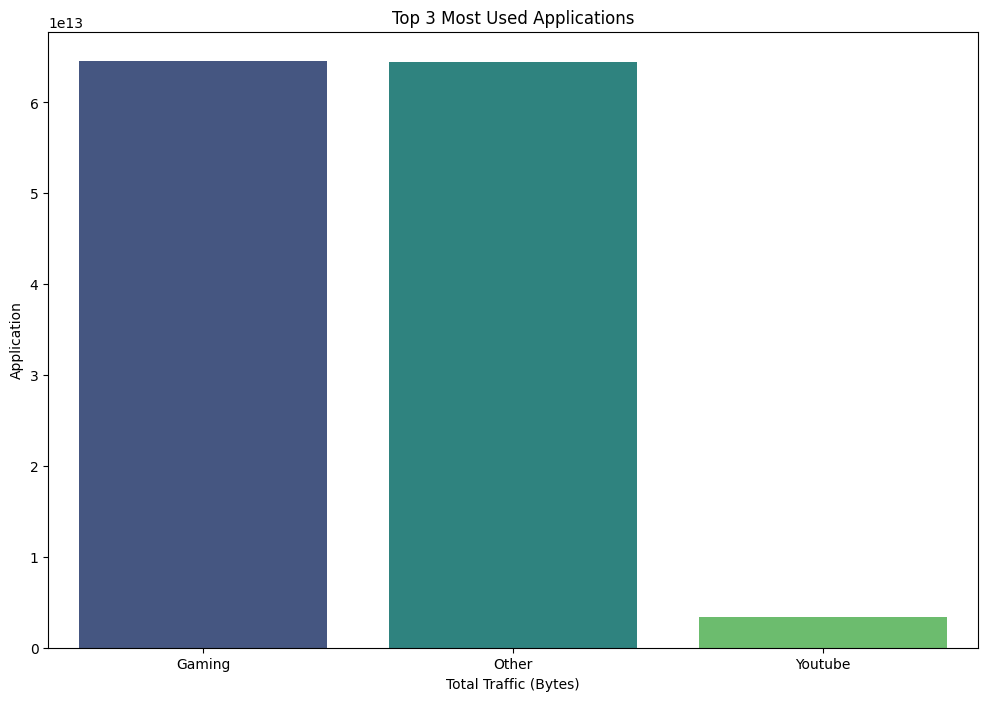

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Check the columns in the DataFrame

# Compute minimum, maximum, average, and total metrics for each cluster
if 'cluster' in df_user_engagement.columns:  # Replace 'cluster' with your actual clustering column if needed
    cluster_metrics = df_user_engagement.groupby('cluster').agg({
        'Social Media DL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Social Media UL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Google DL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Google UL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Email DL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Email UL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Youtube DL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Youtube UL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Netflix DL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Netflix UL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Gaming DL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Gaming UL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Other DL (Bytes)': ['min', 'max', 'mean', 'sum'],
        'Other UL (Bytes)': ['min', 'max', 'mean', 'sum']
    })
    print("Cluster Metrics:")
    print(cluster_metrics)
else:
    print("Cluster column not found in DataFrame. Please check column names.")

# Aggregate user total traffic per application
applications = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']
user_engagement = pd.DataFrame()

for app in applications:
    app_dl = f'{app} DL (Bytes)'
    app_ul = f'{app} UL (Bytes)'
    
    if app_dl in df_user_engagement.columns and app_ul in df_user_engagement.columns:
        user_engagement[f'{app}_total_traffic'] = df_user_engagement.groupby('MSISDN/Number')[[app_dl, app_ul]].sum().sum(axis=1)
        
        # Top 10 users per application by traffic
        top_users = user_engagement[[f'{app}_total_traffic']].sort_values(f'{app}_total_traffic', ascending=False).head(10)
        print(f"Top 10 users by {app} traffic:")
        print(top_users)
    else:
        print(f"Columns for {app} not found in DataFrame.")

# Plotting the top 3 most used applications
# Calculate total traffic for each application
total_traffic = {app: user_engagement[f'{app}_total_traffic'].sum() for app in applications if f'{app}_total_traffic' in user_engagement.columns}
top_3_apps = sorted(total_traffic.items(), key=lambda x: x[1], reverse=True)[:3]

# Create a DataFrame for plotting
top_3_df = pd.DataFrame(top_3_apps, columns=['Application', 'Total Traffic'])

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(y='Total Traffic', x='Application', data=top_3_df, palette='viridis')
plt.title('Top 3 Most Used Applications')
plt.xlabel('Total Traffic (Bytes)')
plt.ylabel('Application')
plt.show()


Top 10 users by Social Media traffic:
               Social Media_total_traffic
MSISDN/Number                            
0.000000e+00                 1.973817e+09
3.362632e+10                 4.337478e+07
3.376054e+10                 3.978319e+07
3.365973e+10                 3.541236e+07
3.361489e+10                 2.829454e+07
3.362578e+10                 2.713550e+07
3.366716e+10                 2.424785e+07
3.378632e+10                 2.397492e+07
3.366907e+10                 2.380083e+07
3.360313e+10                 2.307782e+07
Top 10 users by Google traffic:
               Google_total_traffic
MSISDN/Number                      
0.000000e+00           8.248577e+09
3.362632e+10           1.521919e+08
3.362578e+10           1.423079e+08
3.361489e+10           1.279738e+08
3.376054e+10           1.232231e+08
3.365973e+10           1.165163e+08
3.378632e+10           1.102545e+08
3.367588e+10           1.098605e+08
3.366716e+10           1.050327e+08
3.376127e+10           9.70899

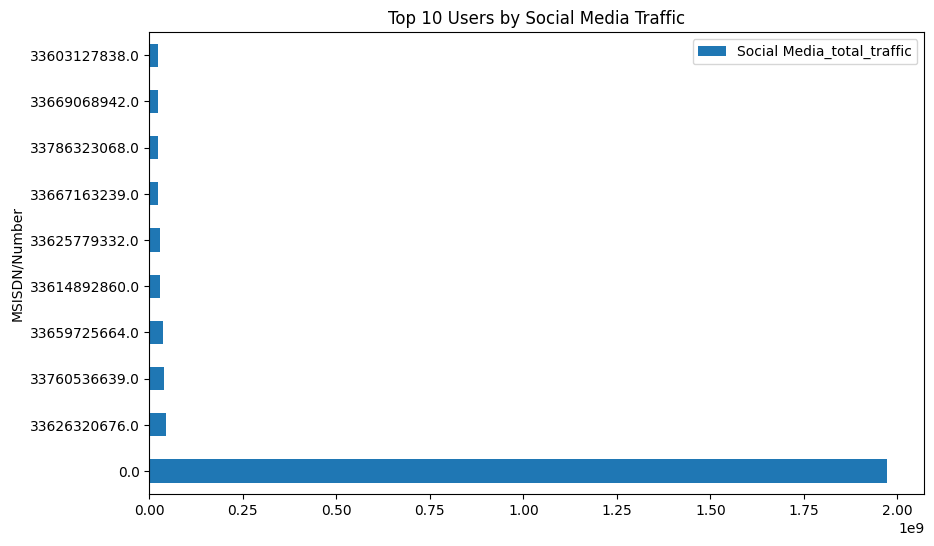

In [22]:
# Aggregating total traffic per application and identifying the top 10 users
applications = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']
for app in applications:
    app_dl = f'{app} DL (Bytes)'
    app_ul = f'{app} UL (Bytes)'
    
    user_engagement[f'{app}_total_traffic'] = df_user_engagement.groupby('MSISDN/Number')[[app_dl, app_ul]].sum().sum(axis=1)
    
    # Top 10 users per application by traffic
    print(f"Top 10 users by {app} traffic:")
    print(user_engagement[[f'{app}_total_traffic']].sort_values(f'{app}_total_traffic', ascending=False).head(10))

# Plotting for one application (e.g., Social Media)
top_users_social_media = user_engagement[['Social Media_total_traffic']].sort_values('Social Media_total_traffic', ascending=False).head(10)
top_users_social_media.plot(kind='barh', figsize=(10, 6), title="Top 10 Users by Social Media Traffic")
plt.show()


In [29]:
# Verify and correct the column name
corrected_column_name = 'MSISDN/Number'  # Make sure this matches exactly with the DataFrame column name

# List of applications
applications = ['Social Media', 'Google', 'Email', 'Youtube', 'Netflix', 'Gaming', 'Other']

# Initialize an empty DataFrame for user engagement
user_engagement = pd.DataFrame()

for app in applications:
    app_dl = f'{app} DL (Bytes)'
    app_ul = f'{app} UL (Bytes)'

    # Ensure columns exist in the DataFrame
    if app_dl in df_user_engagement.columns and app_ul in df_user_engagement.columns:
        # Aggregating total traffic per application
        user_engagement[f'{app}_total_traffic'] = df_user_engagement.groupby(corrected_column_name)[[app_dl, app_ul]].sum().sum(axis=1)
        
        # Top 10 users per application by traffic
        print(f"Top 10 users by {app} traffic:")
        print(user_engagement[[f'{app}_total_traffic']].sort_values(f'{app}_total_traffic', ascending=False).head(10))
    else:
        print(f"Columns {app_dl} and/or {app_ul} do not exist in the DataFrame.")


Top 10 users by Social Media traffic:
               Social Media_total_traffic
MSISDN/Number                            
0.000000e+00                 1.973817e+09
3.362632e+10                 4.337478e+07
3.376054e+10                 3.978319e+07
3.365973e+10                 3.541236e+07
3.361489e+10                 2.829454e+07
3.362578e+10                 2.713550e+07
3.366716e+10                 2.424785e+07
3.378632e+10                 2.397492e+07
3.366907e+10                 2.380083e+07
3.360313e+10                 2.307782e+07
Top 10 users by Google traffic:
               Google_total_traffic
MSISDN/Number                      
0.000000e+00           8.248577e+09
3.362632e+10           1.521919e+08
3.362578e+10           1.423079e+08
3.361489e+10           1.279738e+08
3.376054e+10           1.232231e+08
3.365973e+10           1.165163e+08
3.378632e+10           1.102545e+08
3.367588e+10           1.098605e+08
3.366716e+10           1.050327e+08
3.376127e+10           9.70899

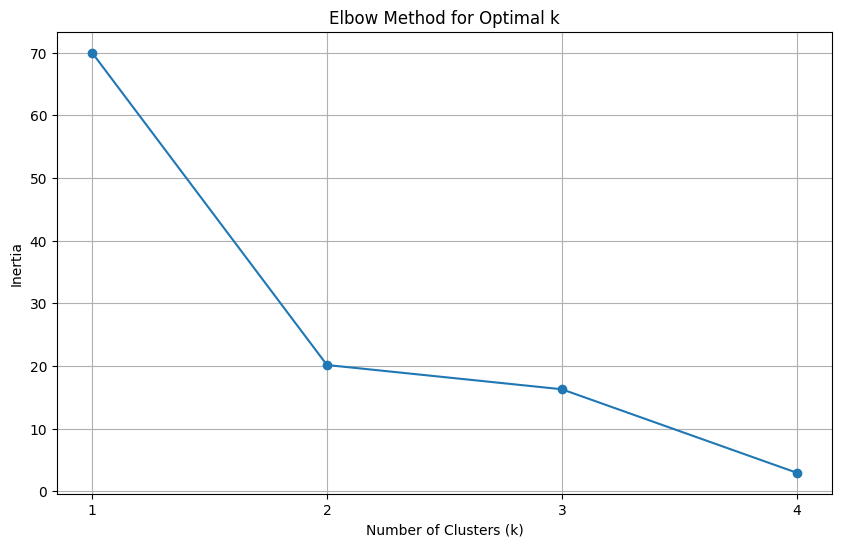

Cluster Metrics:
        Social Media DL (Bytes)                           \
                            min   max         mean   sum   
cluster                                                    
0                          1500  2000  1766.666667  5300   
1                          1200  1200  1200.000000  1200   
2                          1000  1000  1000.000000  1000   

        Social Media UL (Bytes)                   Google DL (Bytes)        \
                            min  max   mean   sum               min   max   
cluster                                                                     
0                           600  700  650.0  1950              2500  3000   
1                           550  550  550.0   550              2200  2200   
2                           500  500  500.0   500              2000  2000   

         ... Gaming UL (Bytes)       Other DL (Bytes)                    \
         ...              mean   sum              min  max   mean   sum   
cluster  

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Load your data
# df_user_engagement = pd.read_csv('path_to_your_data.csv')  # Uncomment and adjust as necessary

# Sample DataFrame for demonstration purposes
# Replace this with your actual DataFrame loading code
data = {
    'MSISDN/Number': ['user1', 'user2', 'user3', 'user4', 'user5'],
    'Social Media DL (Bytes)': [1000, 1500, 2000, 1200, 1800],
    'Social Media UL (Bytes)': [500, 600, 700, 550, 650],
    'Google DL (Bytes)': [2000, 2500, 3000, 2200, 2700],
    'Google UL (Bytes)': [1000, 1200, 1400, 1100, 1300],
    'Email DL (Bytes)': [1500, 1600, 1700, 1400, 1550],
    'Email UL (Bytes)': [600, 650, 700, 550, 600],
    'Youtube DL (Bytes)': [2500, 3000, 3500, 2700, 3200],
    'Youtube UL (Bytes)': [1200, 1300, 1400, 1150, 1250],
    'Netflix DL (Bytes)': [3000, 3500, 4000, 3200, 3700],
    'Netflix UL (Bytes)': [1400, 1500, 1600, 1300, 1450],
    'Gaming DL (Bytes)': [2000, 2200, 2400, 2100, 2300],
    'Gaming UL (Bytes)': [800, 850, 900, 750, 850],
    'Other DL (Bytes)': [500, 600, 700, 550, 650],
    'Other UL (Bytes)': [200, 250, 300, 180, 220],
}

df_user_engagement = pd.DataFrame(data)

# Aggregate metrics per customer ID (MSISDN)
aggregated_metrics = df_user_engagement.groupby('MSISDN/Number').agg({
    'Social Media DL (Bytes)': 'sum',
    'Social Media UL (Bytes)': 'sum',
    'Google DL (Bytes)': 'sum',
    'Google UL (Bytes)': 'sum',
    'Email DL (Bytes)': 'sum',
    'Email UL (Bytes)': 'sum',
    'Youtube DL (Bytes)': 'sum',
    'Youtube UL (Bytes)': 'sum',
    'Netflix DL (Bytes)': 'sum',
    'Netflix UL (Bytes)': 'sum',
    'Gaming DL (Bytes)': 'sum',
    'Gaming UL (Bytes)': 'sum',
    'Other DL (Bytes)': 'sum',
    'Other UL (Bytes)': 'sum',
})

# Normalize the metrics
scaler = StandardScaler()
normalized_metrics = scaler.fit_transform(aggregated_metrics)

# Determine optimal k using the Elbow Method
inertia = []
k_range = range(1, min(len(aggregated_metrics), 11))  # Ensure k does not exceed number of samples

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_metrics)
    inertia.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

# Based on the elbow plot, choose the optimal k (usually where the curve starts to flatten)
optimal_k = 3  # Replace with the value you determine from the elbow plot

# Fit k-means with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
df_user_engagement['cluster'] = kmeans.fit_predict(normalized_metrics)

# Compute min, max, average, and total non-normalized metrics for each cluster
cluster_metrics = df_user_engagement.groupby('cluster').agg({
    'Social Media DL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Social Media UL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Google DL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Google UL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Email DL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Email UL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Youtube DL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Youtube UL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Netflix DL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Netflix UL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Gaming DL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Gaming UL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Other DL (Bytes)': ['min', 'max', 'mean', 'sum'],
    'Other UL (Bytes)': ['min', 'max', 'mean', 'sum']
})

print("Cluster Metrics:")
print(cluster_metrics)
